# Taylor Expansion of a decoupled System

In the Paper 'Design of Decoupled Controllers for MIMO Systems' by Aström, Johansson and Wang the Decoupling for small frequencies is described.

The following calculation is based on the First Order Time Delay (FOTD) Identification method, which results in a Two Input Two Output (TITO) System for the System in feedforward representation. 

To Decouple the system a Taylor Series around the steady state s=0 is used to derive Interaction from an input to another output. Since we approximate the system always with a FOTD Model, we can derive the interaction:

In [1]:
# Import the needed packages, SymPy
import sympy as sp
from sympy import init_printing
init_printing()

In [2]:
# Define the variables
# Complex variable
s = sp.symbols('s')
# FOTD Coeffficients
T1,T2,T3,T4 = sp.symbols('T_1 T_2 T_3 T_4')
K1,K2,K3,K4 = sp.symbols('K_1 K_2 K_3 K_4')
# Time Delay Coefficients
L1,L2,L3,L4 = sp.symbols('L_1 L_2 L_3 L_4')

# Vectorize
TV = [T1,T2,T3,T4]
KV = [K1,K2,K3,K4]
LV = [L1,L2,L3,L4]

# Define a FOTD
def FOTD(K,T,L):
    return K/(T*s+1) * sp.exp(-L*s)

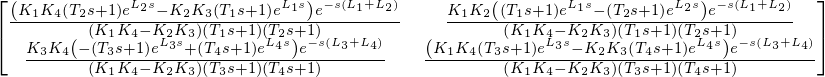

In [3]:
#Define a Matrix of FOTD
G = sp.zeros(2)
for i in range(0,4):
    G[i]= FOTD(KV[i],TV[i],LV[i])

#Get the DC Gain and invert it for Static Decoupling 
G0 = G.subs(s,0)
D = sp.simplify(G0**-1)

#Get the Q Matrix -> the static decoupled system
Q = sp.simplify(G*D)
Q

In [4]:
# Get the Taylor series Expansion for the Interaction of Q approx I + O(s)
k12 = sp.simplify(Q[1].series(s,0,2).removeO())
k21 = sp.simplify(Q[2].series(s,0,2).removeO())

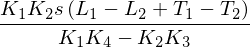

In [5]:
# Print the Interaction of Input 2 on Output 1 in small frequencies
k12

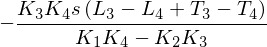

In [6]:
# Print the Interaction of Input 1 on Output 2 in small frequencies
k21

# Interpretation

We can see that the inverse of the determinant of the DCGain is a scaling factor describing the influence of the main diagonal elements in relation to the off diagonal elements. Hence, if the matrix is nearly equal in its gains the interaction is large.

The scaling is completed with the influence of the gains of the row affecting the output.

The results of the calculation give a direct interpretation:
Consider a TITO system described by FOTD functions. The Influence of the static decoupled system Q from an input i on an output j is neglectable iff:

- $T_i = T_j$ and $L_i = L_j$
- $T_i = L_j$ and $T_j = L_i$
- $K_i K_j \leq 1$ and $det(G_0) \geq 1$

# Decomposition of the Interaction

Since we want to directly apply the AMIGO procedure, we can state that:

$Q C^* = G \underbrace{D C}_{C^*} = G C'$

Where $C'$ is the controller we would design from the regular system. Hence, we force the regular controller to behave like the ideal, decoupling controller.

$ D C = C'$

Or to get the decoupling controller as a function of the regular controller:

$C = D^{-1} C'$

In [7]:
# Define the symbols for interaction
k1,k2 = sp.symbols('k_1 k_2', real = True) 
c1,c2 = sp.symbols('c_1 c_2',real = True)
# Define symbols for the decoupling controller --> SMALL LETTER
ki1,ki2 = sp.symbols('k_{i1} k_{i2}',real = True)
kp1,kp2 = sp.symbols('k_{p1} k_{p2}',real = True)
b = sp.symbols('b',real = True)
# Define the symbols for the regular controller
KI1,KI2,KI3,KI4 = sp.symbols('K_{I1} K_{I2} K_{I3} K_{I4}',real = True)
KP1,KP2,KP3,KP4 = sp.symbols('K_{P1} K_{P2} K_{P3} K_{P4}',real = True)
B = sp.symbols('B',real = True)
# Vectorize
kV = [k1,k2]
cV = [c1,c2]
kiV = [ki1,ki2]
kpV = [kp1,kp2]
solvar =[ki1,ki2,kp1,kp2]
KIV = [KI1,KI2,KI3,KI4]
KPV = [KP1,KP2,KP3,KP4]

In [8]:
# Create a symbolic Controller
def PI(I,P,S):
    # Here S is setpointweight
    return P*S+I/s

# Create an decoupling controller for the 
C_D = sp.diag(PI(ki1,kp1,1),PI(ki2,kp2,1))
# Create the regular controller
C_R = sp.zeros(2)
for i in range(0,4):
    C_R[i]= PI(KIV[i],KPV[i],1)

C_RD = G.subs(s,0) * C_R

# Get substituion Rules -> make a list of equations
EQ = []
for i in range(0,4):
    EQ.append(C_D[i]- C_RD[i])

We now have a system of 4 Equations we can set to zero. We have to solve for four variables, the parameter of the decoupling controller, to get the desired connection from the heueristic rules for FOTD Systems to the more complex system.

We can divide these four equations into two Blocks:
- Block one, containing the decoupled controller, we can use to solve for the decoupling controller
- Block two, containing information about the ratio between the relation of the four controller

So use the following algorithm:
- Pick two Transfer functions from the system $G(s)$
- Use the static gains to solve for relation which is needed for the two and reduce the equations to two regular controllers in relation with each other
- Solve for kI

In [10]:
# Solve for the Integral parts of the decoupling controllers
kiEQ = [EQ[0],EQ[3]]
kisol = sp.solve(kiEQ,[C_D[0],C_D[3]],dict=True)
# Solve for the ratio of the regular controllers
KEQ = [EQ[1],EQ[2]]
# Choose to substitute the minor diagonals -> solve 
Ksol = sp.solve(KEQ,[C_R[1],C_R[2]], dict=True)
# Substitute the minor diagonals in the solution for ki
# We have a system of polynomials! Hence, we can get the right ratio of coefficient analysis
# Regular controller -> First minor diagonal
a = C_R[1] # Chose controller from input 2 to output 1
expr = sp.simplify(Ksol[0][a]).expand()
# Get the coefficients corresponding to 1/s
I12 = expr.coeff('1/s');
# Get the coefficients corresponding to Proportional Gain
P12 = sp.simplify(expr-I12/s)

# Next controller
a = C_R[2]
expr = sp.simplify(Ksol[0][a]).expand()
# Get the coefficients corresponding to 1/s
I21= expr.coeff('1/s')
# Get the coefficients corresponding to Proportional Gain
P21 = sp.simplify(expr-I21/s)

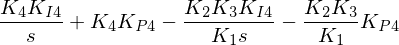

In [11]:
a = C_D[0]
sub1 = kisol[0][a].subs(KPV[1],P12).subs(KPV[2],P21).subs(KIV[1],I12).subs(KIV[2],I21)
sub1 = sp.simplify(sub1)
a = C_D[3]
sub2 = kisol[0][a].subs(KPV[1],P12).subs(KPV[2],P21).subs(KIV[1],I12).subs(KIV[2],I21)
sub2 = sp.simplify(sub2)
sub2

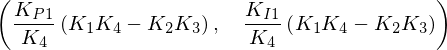

In [12]:
# Decoupling controller 1 -> We can directly see the proportional and integral coeffcients
sp.simplify(sub1-sub1.coeff('1/s')/s),sp.simplify(sub1.coeff('1/s'))

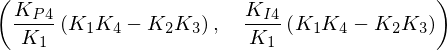

In [13]:
# Decoupling controller 2 -> We can directly see the proportional and integral coeffcients
sp.simplify(sub2-sub2.coeff('1/s')/s),sp.simplify(sub2.coeff('1/s'))

The equations can be interpreted as follows:

- The main diagonal brings the connection between the regular controller designed on behalf the system $G(s)$
- The minor diagonal gives two equations for the regular controller designed by t

In [19]:
# Get the Substituon for Q
q11,q12,q21,q22 = sp.symbols('q_{11} q_{12} q_{21} q_{22}')
q = [q11,q12,q21,q22]
S = sp.zeros(2)
for i in range(0,4):
    S[i] = q[i]

In [25]:
# Stability for loop 1
h12 =(1+q[0]*C_D[0])


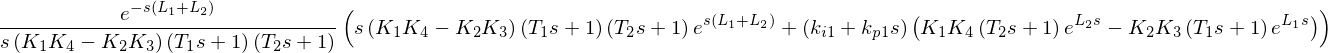

In [26]:
sp.simplify(h12.subs(q[0],Q[0]).subs(q[1],Q[1]).subs(q[2],Q[2]).subs(q[3],Q[3]))